In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector
import re
from nltk.stem import PorterStemmer
import geopandas as gpd

In [2]:
PATH = "D:\MA\MA2\Semester_Project\data"
names_df = pd.read_csv(PATH + "\Building_names.csv")
names_df['Building_name'] = names_df['Building_name'].str.replace('\d+', '')
names_df

C:\Users\youss\AppData\Local\Temp\ipykernel_15916\3118950016.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  names_df['Building_name'] = names_df['Building_name'].str.replace('\d+', '')


,Building_name
0,NORTH PORTICO
1,TURBA OF BARKA KHAN
2,RIBAT OF ALA AL-DIN
3,MUAZZAMIYYA MINARET
4,RIBAT AL-MANSURI
...,...
59,SOUTH-WEST QANATIR
60,RIBAT AL-ZAMANI
61,AL-MUZHIRIYYA
62,AL-ASHRAFTIYYA


In [ ]:
mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()
#insert id values and the building names into the building table
for i in range(len(names_df)):
    sql = "INSERT INTO building (id, name) VALUES (%s, %s)"
    val = (i+1, names_df['Building_name'][i])
    mycursor.execute(sql, val)
    mydb.commit()


In [3]:
infos_df = pd.read_csv(PATH + "\primary_infos.csv")

#replace nan values with empty string
infos_df = infos_df.replace(np.nan, '', regex=True)
infos_df['Infos'] = infos_df['Infos'].str.replace('\n\n', '\n')
infos_df = infos_df[infos_df['Infos'].str.split('\n').str[0].str.contains('/')]

infos_df['date'] = infos_df['Infos'].str.split('\n').str[0]
hij_pattern = r'([\d-]+)(?=/)'
infos_df['hijri'] = [re.findall(hij_pattern, x) for x in infos_df['date']]
infos_df['hijri'] = infos_df['hijri'].str.join(', ')
greg_pattern = r'(?<=/)([\d-]+)'
infos_df['gregorian'] = [re.findall(greg_pattern, x) for x in infos_df['date']]
infos_df['gregorian'] = infos_df['gregorian'].str.join(', ')

infos_df['type'] = infos_df['Infos'].str.split('\n').str[1]
infos_df['modern_name'] = infos_df['Infos'].str.split('\n').str[2].str.split(':').str[1]
#replace Nan with "not known"
infos_df['modern_name'] = infos_df['modern_name'].replace(np.nan, 'unknown', regex=True)


infos_df.head()

,Article_id,Article_name,Infos,date,hijri,gregorian,type,modern_name
1,2,2 TURBA OF BARKA KHAN,Between 663/1265 and 679/1280; extended 792/13...,Between 663/1265 and 679/1280; extended 792/1390,"663, 679, 792","1265, 1280, 1390",Tomb of Barka Khan and his sons,al-Maktabat al-Khalidiyya (Khalidi Library)
2,3,3 RIBAT OF ‘ALA’ AL-DIN,666/1267-68\nPilgrim Hospice of ‘Ala’ al-Din A...,666/1267-68,666,1267-68,Pilgrim Hospice of ‘Ala’ al-Din Aydughdi al-Basir,Habs al-Dam (‘Prison of Blood’)
3,4,4 MU‘AZZAMIYYA MINARET,673/1274-75\nMinaret of the Mu‘azzamiyya Madra...,673/1274-75,673,1274-75,Minaret of the Mu‘azzamiyya Madrasa,Minaret of ‘Masjid al-Mujahidin’
4,5,5 RIBAT AL-MANSURI,681/1282-83\nPilgrim Hospice of Sultan Qalawin...,681/1282-83,681,1282-83,Pilgrim Hospice of Sultan Qalawin,Habs al-Ribat (Hospice Prison’)
5,6,6 AL-KUBAKIYYA,€.688/1289\nTomb of ‘Ala’ al-Din Aydughdi al-K...,€.688/1289,688,1289,Tomb of ‘Ala’ al-Din Aydughdi al-Kubaki,"not known"""


In [ ]:
mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()
#in the building table, insert type and modern_name values
#in the date table, insert the key id, hijri, gregorian, and explanation values
#explanation is the date column if the latter contains text, otherwise it is empty
for row in infos_df.itertuples():
    sql = "UPDATE building SET type = %s, modern_name = %s, date_id = %s WHERE id = %s"
    val = (row.type, row.modern_name, row.Article_id, row.Article_id)
    mycursor.execute(sql, val)
    mydb.commit()
    # text = re.search('[a-zA-Z]', row.date)   
    # sql = "INSERT INTO date (id, hijri, gregorian, explanation) VALUES (%s, %s, %s, %s)"
    # val = (row.Article_id, row.hijri, row.gregorian, row.date if text!=None else '')
    # mycursor.execute(sql, val)
    # mydb.commit()

In [4]:
df_read = pd.read_csv(PATH + "/articles.csv")
df_read["Text"] = df_read["Text"].astype(str)
df_read["Title"] = df_read["Title"].astype(str)


In [5]:
def extract_titles(text):
    roman_numerals = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X", "Ill"]
    pattern = re.compile(r"(" + "|".join(roman_numerals) + r")\s([A-Z]+)")
    titles = pattern.findall(text)
    return titles

In [6]:
#cleaning
clean_df = df_read.copy()
#keep only capital letters and spaces from titles
clean_df["Title"] = clean_df["Title"].str.replace("[^A-Z ]", "").str.strip()

#replace \n with a space in the text
#clean_df["Text"] = clean_df["Text"].str.replace("\n", " ")

clean_df = clean_df.drop(clean_df[(clean_df["Title"] == "") & (clean_df["Text"] == "nan")].index).reset_index(drop=True)

clean_df = clean_df.drop(clean_df[(clean_df["Article_id"] == 14) |
                                  (clean_df["Article_id"] == 68) |
                                  (clean_df["Text"].isna())].index).reset_index(drop=True)

stemmer = PorterStemmer()

#if a text contains a title, create a new row with the title and the text that comes after
#delete that title and what comes after from the text
for i, row in clean_df.iterrows():
    inner_titles = extract_titles(row["Text"])
   
    if len(inner_titles) > 0:
        for title in inner_titles:
            title_root = stemmer.stem(title[1])
            if title_root in [stemmer.stem(t) for t in clean_df["Title"]] and len(title[1]) > 2:
                #split the text into two parts: the text before the title and the text after the title
                text_before_title = row["Text"].split(title[0] + " " + title[1])[0]
                text_after_title = row["Text"].split(title[0] + " " + title[1])[1]
                #delete the title and what comes after from the text
                clean_df.at[i, "Text"] = text_before_title
                #add a new row with the title and the text that comes after
                new_line = pd.DataFrame({"Article_id": [row["Article_id"]], "Title": [title[0] + " " + title[1]], "Text": [text_after_title]})
                #add it just after the row with same id
                clean_df = pd.concat([clean_df.iloc[:i+1], new_line, clean_df.iloc[i+1:]]).reset_index(drop=True)
                i += 1
            
numbers = clean_df["Article_id"].unique()
for i, number in enumerate(numbers):
    if number != i+1:
        clean_df.loc[clean_df["Article_id"] == number, "Article_id"] = i+1
        #update the index
        i += 1

clean_df

C:\Users\youss\AppData\Local\Temp\ipykernel_15724\3259853338.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_df["Title"] = clean_df["Title"].str.replace("[^A-Z ]", "").str.strip()


,Article_id,Title,Text
0,1,I SITE AND BUILDING,Herod’s temple enclosure (the lines of which a...
1,1,Ill HISTORY,\n\nAl-‘Umari (¢.745/1345) described the north...
2,2,I LOCATION,At the south-east corner of the junction betwe...
3,2,I SITE AND BUILDINGS,"The site is bounded by the street, Tariq Bab a..."
4,2,IV ARCHITECTURE,"STREET FACADE (fig. 2.4, plate 2.1)\n\nSince t..."
...,...,...,...
229,63,IV ARCHITECTURE,GROUND FLOOR (fig. 63.3)\n\n(i) Assembly hall\...
230,64,I LOCATION,On the Haram esplanade about 15m north-east of...
231,64,II SITE AND BUILDING,The sabil is situated at the north-west corner...
232,64,I HISTORY,"ee ee,\n\nLittle of the early history of the s..."


In [7]:
#inscriptions
insc_df = clean_df.copy()
inscription_root = stemmer.stem("inscription")

#add these as a new column to the dataframe
insc_df["Inscription"] = [[] for i in range(insc_df.shape[0])]
test_text = ""
for i, row in insc_df.iterrows():
    sentences = re.findall(r"[^.;!?]*(?:[.;!?])", row["Text"])
    for j, sentence in enumerate(sentences):
        #sentence should contain a ':' and contain the root of 'inscription' before the ':'
        if ":" in sentence :
            after = sentence.split(":")[1]
            if len(after) > 0 and "\n\n" in after[:3]:
                before = sentence.split(":")[0]
                clean_before = re.sub(r'[^a-zA-Z ]', '', before.replace("\n", " "))
                #clean_before = before.replace("\n", " ").replace("[^a-zA-Z]", "")#.replace(",", "")
                before_before = sentences[j-1]
                clean_before_before = re.sub(r'[^a-zA-Z ]', '', before_before.replace("\n", " "))
                #while the sentence before is shorter than 3 characters, go back to the previous sentence
                while len(before_before) < 10:
                    j -= 1
                    before_before = sentences[j-1]
                    clean_before_before = re.sub(r'[^a-zA-Z ]', '', before_before.replace("\n", " "))
                #clean_before_before = before_before.replace("\n", " ").replace("[^a-zA-Z]", "")#.replace(",", "")
                if (inscription_root in [stemmer.stem(word) for word in clean_before.split(" ")]
                    or inscription_root in [stemmer.stem(word) for word in clean_before_before.split(" ")]):
                    
                    #add all next sentences until founding "\n\n"
                    #inscription = before + ":"
                    #delete \n\n and replace \n with a space
                    after = after.replace("\n\n", "").replace("\n", " ")
                    inscription = after
                    k = j+1
                     
                    while k < len(sentences) and "\n\n" not in sentences[k]:
                        inscription += sentences[k]
                        k += 1
                    inscription += sentences[k].split("\n\n")[0]
                    #add the inscription to the dataframe
                    insc_df.at[i, "Inscription"].append(inscription)
                
insc_df

,Article_id,Title,Text,Inscription
0,1,I SITE AND BUILDING,Herod’s temple enclosure (the lines of which a...,[]
1,1,Ill HISTORY,\n\nAl-‘Umari (¢.745/1345) described the north...,[]
2,2,I LOCATION,At the south-east corner of the junction betwe...,[]
3,2,I SITE AND BUILDINGS,"The site is bounded by the street, Tariq Bab a...",[_.. This is the tomb of the servant needful o...
4,2,IV ARCHITECTURE,"STREET FACADE (fig. 2.4, plate 2.1)\n\nSince t...",[This window and the dome over the tomb (ézerb...
...,...,...,...,...
229,63,IV ARCHITECTURE,GROUND FLOOR (fig. 63.3)\n\n(i) Assembly hall\...,[]
230,64,I LOCATION,On the Haram esplanade about 15m north-east of...,[]
231,64,II SITE AND BUILDING,The sabil is situated at the north-west corner...,[]
232,64,I HISTORY,"ee ee,\n\nLittle of the early history of the s...",[]


In [10]:
insc_df['Inscription_tuple'] = insc_df['Inscription'].apply(tuple)

# Drop duplicates based on tuples
insc_df = insc_df.drop_duplicates(subset='Inscription_tuple', keep='first')

# Remove the temporary tuple column
insc_df = insc_df.drop('Inscription_tuple', axis=1)

# Convert column of tuples back to column of lists if needed
insc_df['Inscription'] = insc_df['Inscription'].apply(list)
insc_df.head()

,Article_id,Title,Text,Inscription
0,1,I SITE AND BUILDING,Herod’s temple enclosure (the lines of which a...,[]
3,2,I SITE AND BUILDINGS,"The site is bounded by the street, Tariq Bab a...",[_.. This is the tomb of the servant needful o...
4,2,IV ARCHITECTURE,"STREET FACADE (fig. 2.4, plate 2.1)\n\nSince t...",[This window and the dome over the tomb (ézerb...
14,5,I HISTORY,IDENTIFICATION\n\nThe building is fully indent...,"[4In the name of God the Compassionate, the Me..."
17,6,Ill HISTORY,\n\nA dedicatory inscription above the entranc...,[... This is the tomb (tzrba) of .. . the Amir...


In [11]:
nb_inscriptions = 0
for i, row in insc_df.iterrows():
    if len(row["Inscription"]) > 0:
        print(row["Article_id"], len(row["Inscription"]), row["Inscription"])
        nb_inscriptions += len(row["Inscription"])
        print("\n")

print("Number of inscriptions:", nb_inscriptions)

2 2 ["_.. This is the tomb of the servant needful of God's mercy\nand forgiveness, Barkatkhan [sic] (may God illumine his\nresting-place). He died on Friday, the first day of\nMuharram in the year 644 [18 May 1246]... ”", 'The Amir Husam al-Din Barka Khan b. Dawlat Khan,’ after\nwhom the turba is named, was one of the four chiefs, and the\nmost important one, of the Khwarizmian bands who operated\nin Mesopotamia, Syria and Palestine in the 1230s and 1240s.\nThey were the remnants, no doubt of mixed ethnic origin, of\nthe army of the Khwarizm Shah, whose empire had been\nshattered by the Mongols. After the death of Jalal al-Din, the son\nof the last Khwarizm Shah, this soldiery became ever more a\nthreat to the economy and security of the area.’ The Ayyubid\nSultan al-Salih Ayyab had attempted to use them as an\ninstrument of his policy. He married a half-sister of his to Barka\nKhan.’ In the end the power of the Khwarizmiyya was broken\nin a battle south of Homs, which took place in Mu

In [13]:
mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()
j=1
for i, row in insc_df.iterrows():
    inscriptions = row["Inscription"]
    if len(inscriptions) > 0:
        for inscription in inscriptions:
            # sql = "INSERT INTO inscription (id, building_id, text) VALUES (%s, %s, %s)"
            # val = (j, row["Article_id"], inscription)
            # mycursor.execute(sql, val)
            # mydb.commit()
            #update tha table by inserting title in the reference column
            sql = "UPDATE inscription SET reference = %s WHERE id = %s"
            val = (row["Title"], j)
            mycursor.execute(sql, val)
            mydb.commit()
            j+=1



In [4]:
gdf = gpd.read_file(PATH + "/mamluk_jerusalem_buildings_location.geojson")
gdf['CRS'] = gdf.crs
gdf['longitude'] = gdf['geometry'].x
gdf['latitude'] = gdf['geometry'].y
#gdf = gdf.drop('geometry', axis=1)
gdf

,id,geometry,CRS,longitude,latitude
0,1,POINT (172320.418 1131919.166),EPSG:28193,172320.417613,1.131919e+06
1,51,POINT (172302.896 1131923.462),EPSG:28193,172302.896327,1.131923e+06
2,33,POINT (172326.102 1131926.822),EPSG:28193,172326.101890,1.131927e+06
3,26,POINT (172340.939 1131928.533),EPSG:28193,172340.939371,1.131929e+06
4,30,POINT (172348.000 1131927.644),EPSG:28193,172347.999507,1.131928e+06
...,...,...,...,...,...
59,17,POINT (172410.499 1131810.399),EPSG:28193,172410.499344,1.131810e+06
60,39,POINT (172241.023 1132104.660),EPSG:28193,172241.023132,1.132105e+06
61,41,POINT (171942.851 1132094.440),EPSG:28193,171942.850891,1.132094e+06
62,46,POINT (172043.974 1131690.613),EPSG:28193,172043.973550,1.131691e+06


In [9]:
mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()

#convert the CRS to string
gdf['CRS'] = gdf['CRS'].astype(str)


for i, row in gdf.iterrows():
    #add id, longitude and latitude to the table location
    sql = "INSERT INTO location (id, longitude, latitude) VALUES (%s, %s, %s)"
    val = (row["id"], row["longitude"], row["latitude"])
    mycursor.execute(sql, val)
    mydb.commit()
    #insert id in the attribute loc_id of the table building
    sql = "UPDATE building SET loc_id = %s WHERE id = %s"
    val = (row["id"], row["id"])
    mycursor.execute(sql, val)
    mydb.commit()

    #update the table location by adding the CRS and geometry
    sql = "UPDATE location SET CRS = %s WHERE id = %s"
    val = (row["CRS"], row["id"])
    mycursor.execute(sql, val)
    mydb.commit()

In [30]:
#neighbours
#filter from clean_df rows where title contains the stemming of location
stemmer = PorterStemmer()
location_root = stemmer.stem("location")
neighbours_df = clean_df.copy()
neighbours_df["Title"] = neighbours_df["Title"].apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x).lower())
neighbours_df["Title"] = neighbours_df["Title"].apply(lambda x: [stemmer.stem(word) for word in x.split(" ")])
neighbours_df = neighbours_df[neighbours_df["Title"].apply(lambda x: location_root in x)]
neighbours_df = neighbours_df.reset_index(drop=True)
neighbours_df


,Article_id,Title,Text
0,2,"[i, locat]",At the south-east corner of the junction betwe...
1,3,"[i, locat]",On the north side of Tariq Bab al-Nazir about ...
2,4,"[i, locat]","Attached to the Mu‘azzamiyya Madrasa, on the s..."
3,5,"[i, locat]","On the south side of Tariq Bab al-Nazir, oppos..."
4,6,"[i, locat]",In a picturesque grove towards the east end of...
5,7,"[i, locat]","Atthe west border of the Haram, abutting the H..."
6,8,"[i, locat]",On the east side of Tariq Bab al-‘Atm' contigu...
7,9,"[i, locat]",On the west side of Tariq Bab Hitta next to th...
8,13,"[i, locat]",On the north side of Tariq Bab al-Silsila wher...
9,14,"[i, locat]",At the north border of the Haram above the roc...


In [ ]:
mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()

for i, row in neighbours_df.iterrows():
    #add text to the neighbours attribute of location
    #if text has a length < 256 characters
    if len(row["Text"]) < 256:
        sql = "UPDATE location SET neighbours = %s WHERE id = %s"
        val = (row["Text"], row["Article_id"])
        mycursor.execute(sql, val)
        mydb.commit()
 

In [29]:
#architecture
arch_df = clean_df.copy()
arch_root = stemmer.stem("architecture")
arch_df["Title"] = arch_df["Title"].apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x).lower())
arch_df["Title"] = arch_df["Title"].apply(lambda x: [stemmer.stem(word) for word in x.split(" ")])
arch_df = arch_df[arch_df["Title"].apply(lambda x: arch_root in x)]
arch_df = arch_df.reset_index(drop=True)
arch_df["others"] = arch_df["Text"]

#split text into paragraphs: each paragraph starts and ends with \n\n
arch_df["Text"] = arch_df["Text"].apply(lambda x: x.split("\n\n"))

#drop others = nan
arch_df = arch_df[arch_df["others"] != "nan"]
arch_df = arch_df.reset_index(drop=True)
arch_df.head()

,Article_id,Title,Text,others
0,2,"[iv, architectur]","[STREET FACADE (fig. 2.4, plate 2.1), Since th...","STREET FACADE (fig. 2.4, plate 2.1)\n\nSince t..."
1,3,"[iv, architectur]",[STREET FRONTAGE (fig. 3.4)\nThe Ribat of ‘Ala...,STREET FRONTAGE (fig. 3.4)\nThe Ribat of ‘Ala’...
2,4,"[iv, architectur]","[A simple stone tower, square in plan, the min...","A simple stone tower, square in plan, the mina..."
3,5,"[iv, architectur]",[STREET FRONTAGE (fig. 5.4)\nThe street fronta...,STREET FRONTAGE (fig. 5.4)\nThe street frontag...
4,6,"[iv, architectur]","[EXTERIOR (figs. 6.3-6.6), The lowest visible ...",EXTERIOR (figs. 6.3-6.6)\n\nThe lowest visible...


In [11]:
def subtitle_paragraph(df, subtitle, length=1):
    df[subtitle] = ["" for i in range(df.shape[0])]
    for i, row in df.iterrows():
        append = False
        start, end = 0, len(row["Text"])
        for j, paragraph in enumerate(row["Text"]):
            first_word = paragraph.strip().replace("\n", " ")
            first_word = first_word.split(" ")[0:length]
            
            #if first_word different from subtitle, continue
            #subtitle can be two words
            if first_word != subtitle.split(" "):
                continue 
            append = True
            start = j+1
            for k in range(j+2, len(row["Text"])):
                next_first_word = row["Text"][k].replace("\n", " ").split(" ")[0]
                if next_first_word.isupper() and len(re.sub(r'[^a-zA-Z]', '', next_first_word)) > 3:
                    end = k
                    break

        if append:
            df.at[i, subtitle] = row["Text"][start:end]

    #flatten the list of strings into a single string in exterior
    df[subtitle] = df[subtitle].apply(lambda x: " ".join(x) if x != None else None)

In [7]:
def retrieve_subtitles(df):
    df["Subtitles"] = [[] for i in range(df.shape[0])]
    for i, row in df.iterrows():
        for j, paragraph in enumerate(row["Text"]):
            #subtitle is the string before the first \n
            first_line = paragraph.split("\n")[0]
            #if the subtitle has at least one word at the beginning in capital letters, append it
            first_line = first_line.split(" ")
            subtitle = ""
            for word in first_line:
                if word.isupper() and len(re.sub(r'[^a-zA-Z]', '', word)) > 3:
                    subtitle += word + " "
                else:
                    break

            if len(subtitle) > 0:
                df.at[i, "Subtitles"].append(subtitle.strip())

In [43]:
retrieve_subtitles(arch_df)
arch_df["Subtitles"] = arch_df["Subtitles"].apply(lambda x: ", ".join(x) if len(x) > 0 else "")
arch_df.head()

,Article_id,Title,Text,others,Subtitles
0,2,"[iv, architectur]","[STREET FACADE (fig. 2.4, plate 2.1), Since th...","STREET FACADE (fig. 2.4, plate 2.1)\n\nSince t...","STREET FACADE, INTERIOR, INTERPRETATION"
1,3,"[iv, architectur]",[STREET FRONTAGE (fig. 3.4)\nThe Ribat of ‘Ala...,STREET FRONTAGE (fig. 3.4)\nThe Ribat of ‘Ala’...,"STREET FRONTAGE, INTERIOR, TOMB CHAMBER, LAPID..."
2,4,"[iv, architectur]","[A simple stone tower, square in plan, the min...","A simple stone tower, square in plan, the mina...",
3,5,"[iv, architectur]",[STREET FRONTAGE (fig. 5.4)\nThe street fronta...,STREET FRONTAGE (fig. 5.4)\nThe street frontag...,"STREET FRONTAGE, UPPER FAGADE, INTERIOR, TURBA..."
4,6,"[iv, architectur]","[EXTERIOR (figs. 6.3-6.6), The lowest visible ...",EXTERIOR (figs. 6.3-6.6)\n\nThe lowest visible...,"EXTERIOR, INTERIOR"


In [34]:
arch_df = arch_df.fillna("")

mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()

for i, row in arch_df.iterrows():
    #insert Article_id to id of table architecture, exterior to exterior, interior to interior, entrance to entrance
    sql = "INSERT INTO architecture (id, exterior, interior, entrance, others) VALUES (%s, %s, %s, %s, %s)"
    val = (row["Article_id"], row["EXTERIOR"], row["INTERIOR"], row["ENTRANCE"], row["others"])
    mycursor.execute(sql, val)
    mydb.commit()
    #insert Article_id in the attribute arch_id of the table building
    sql = "UPDATE building SET arch_id = %s WHERE id = %s"
    val = (row["Article_id"], row["Article_id"])
    mycursor.execute(sql, val)
    mydb.commit()

    #ipdate the table architecture by inserting the subtitles
    sql = "UPDATE architecture SET subtitles = %s WHERE id = %s"
    val = (row["Subtitles"], row["Article_id"])
    mycursor.execute(sql, val)
    mydb.commit()

In [12]:
#history
hist_df = clean_df.copy()
hist_root = stemmer.stem("history")
hist_df["Title"] = hist_df["Title"].apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x).lower())
hist_df["Title"] = hist_df["Title"].apply(lambda x: [stemmer.stem(word) for word in x.split(" ")])
hist_df = hist_df[hist_df["Title"].apply(lambda x: hist_root in x)]
hist_df = hist_df.reset_index(drop=True)
hist_df["others"] = hist_df["Text"]

#split text into paragraphs: each paragraph starts and ends with \n\n
hist_df["Text"] = hist_df["Text"].apply(lambda x: x.split("\n\n"))
#drop others = nan
hist_df = hist_df[hist_df["others"] != "nan"]
hist_df = hist_df.reset_index(drop=True)
hist_df.head()


,Article_id,Title,Text,others
0,1,"[ill, histori]","[, Al-‘Umari (¢.745/1345) described the north ...",\n\nAl-‘Umari (¢.745/1345) described the north...
1,3,"[i, histori]","[IDENTIFICATION, In the street running up to t...",IDENTIFICATION\n\nIn the street running up to ...
2,5,"[i, histori]","[IDENTIFICATION, The building is fully indenti...",IDENTIFICATION\n\nThe building is fully indent...
3,6,"[ill, histori]","[, A dedicatory inscription above the entrance...",\n\nA dedicatory inscription above the entranc...
4,7,"[i, histori]","[IDENTIFICATION, Although the building is anep...",IDENTIFICATION\n\nAlthough the building is ane...


In [13]:
subtitle_paragraph(hist_df, "IDENTIFICATION")
subtitle_paragraph(hist_df, "FOUNDER")
subtitle_paragraph(hist_df, "DATE")
subtitle_paragraph(hist_df, "ENDOWMENT")
subtitle_paragraph(hist_df, "SUBSEQUENT HISTORY", 2)
retrieve_subtitles(hist_df)
hist_df["Subtitles"] = hist_df["Subtitles"].apply(lambda x: ", ".join(x) if len(x) > 0 else "")
hist_df.head()

,Article_id,Title,Text,others,IDENTIFICATION,FOUNDER,DATE,ENDOWMENT,SUBSEQUENT HISTORY,Subtitles
0,1,"[ill, histori]","[, Al-‘Umari (¢.745/1345) described the north ...",\n\nAl-‘Umari (¢.745/1345) described the north...,,,,,,"BAYS, MINARET, BAYS, BAYS, BAYS, BAYS, BAYS, B..."
1,3,"[i, histori]","[IDENTIFICATION, In the street running up to t...",IDENTIFICATION\n\nIn the street running up to ...,In the street running up to the Gate of the In...,‘Ala’ al-Din Aydughdi was a mamluk of the Ayyu...,"The date, 666/1267-8, is confirmed by Mujir al...","The Ottoman land register, Defter no. 522, con...",,"IDENTIFICATION, DATE, FOUNDER, ENDOWMENT, TATE..."
2,5,"[i, histori]","[IDENTIFICATION, The building is fully indenti...",IDENTIFICATION\n\nThe building is fully indent...,The building is fully indentified by an excell...,This is not the place to give a long detailed ...,"According to the inscription, the order for co...",No details connected with the charitable purpo...,,"IDENTIFICATION, DATE, FOUNDER, ENDOWMENT, MAML..."
3,6,"[ill, histori]","[, A dedicatory inscription above the entrance...",\n\nA dedicatory inscription above the entranc...,,,,,,
4,7,"[i, histori]","[IDENTIFICATION, Although the building is anep...",IDENTIFICATION\n\nAlthough the building is ane...,"Although the building is anepigraphic, identif...","If we continue with Mujir al-Din’s text’, we r...",SUBSEQUENT HISTORY Next to nothing is known ab...,,Next to nothing is known about this hospice. T...,"IDENTIFICATION, FOUNDER, DATE, SUBSEQUENT HIST..."


In [15]:
mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()

for i, row in hist_df.iterrows():
    #insert in the table history: Article_id to id, identification to identification, founder to founder, endowment to endowment, subsequent history to subsequent history, others to others
    sql = "INSERT INTO history (id, identification, founder, endowment, subseq_hist, others) VALUES (%s, %s, %s, %s, %s, %s)"
    val = (row["Article_id"], row["IDENTIFICATION"], row["FOUNDER"], row["ENDOWMENT"], row["SUBSEQUENT HISTORY"], row["others"])
    mycursor.execute(sql, val) 
    mydb.commit()
    #update history table by inserting subtitles
    sql = "UPDATE history SET subtitles = %s WHERE id = %s"
    val = (row["Subtitles"], row["Article_id"])
    mycursor.execute(sql, val)
    mydb.commit()

    #insert date in the attribute others of the table date
    sql = "UPDATE date SET others = %s WHERE id = %s"
    val = (row["DATE"], row["Article_id"])
    mycursor.execute(sql, val)
    mydb.commit()

    #update building table by inserting Article_id in the attribute hist_id
    sql = "UPDATE building SET hist_id = %s WHERE id = %s"
    val = (row["Article_id"], row["Article_id"])
    mycursor.execute(sql, val)
    mydb.commit()


In [3]:
mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()
#read the table building in a dataframe
mycursor.execute("SELECT * FROM building")
building_df = pd.DataFrame(mycursor.fetchall())
building_df.columns = [i[0] for i in mycursor.description]
building_df.head()


,id,name,type,modern_name,loc_id,arch_id,hist_id,date_id
0,1,NORTH PORTICO,None,None,1,NaN,1.0,NaN
1,2,TURBA OF BARKA KHAN,Tomb of Barka Khan and his sons,al-Maktabat al-Khalidiyya (Khalidi Library),2,2.0,NaN,2.0
2,3,RIBAT OF ALA AL-DIN,Pilgrim Hospice of ‘Ala’ al-Din Aydughdi al-Basir,Habs al-Dam (‘Prison of Blood’),3,3.0,3.0,3.0
3,4,MUAZZAMIYYA MINARET,Minaret of the Mu‘azzamiyya Madrasa,Minaret of ‘Masjid al-Mujahidin’,4,4.0,NaN,4.0
4,5,RIBAT AL-MANSURI,Pilgrim Hospice of Sultan Qalawin,Habs al-Ribat (Hospice Prison’),5,5.0,5.0,5.0


In [11]:
print("name column precision: ", 1 - building_df["name"].isna().sum()/building_df.shape[0])
print("date_id column precision: ", 1 - building_df["date_id"].isna().sum()/building_df.shape[0])
print("type column precision: ", 1 - building_df["type"].isna().sum()/building_df.shape[0])
print("modern_name column precision: ", 1 - building_df["modern_name"].isna().sum()/building_df.shape[0])
print("hist_id column precision: ", 1 - building_df["hist_id"].isna().sum()/building_df.shape[0])
print("arch_id column precision: ", 1 - building_df["arch_id"].isna().sum()/building_df.shape[0])


name column precision:  1.0
date_id column precision:  0.84375
type column precision:  0.859375
modern_name column precision:  0.859375
hist_id column precision:  0.90625
arch_id column precision:  0.828125


Execution time of query   SELECT * FROM building WHERE name = ' AL-MANJAKIYYA' :  0.0020270347595214844 s
Execution time of query   SELECT * FROM building :  0.0 s
Execution time of query   SELECT name, modern_name FROM building :  0.0 s
Execution time of query   SELECT COUNT(*) FROM date :  0.0061550140380859375 s
Execution time of query   SELECT COUNT(DISTINCT subtitles) FROM architecture :  0.0020551681518554688 s
Execution time of query   SELECT * FROM building JOIN date ON building.date_id = date.id :  0.001674652099609375 s


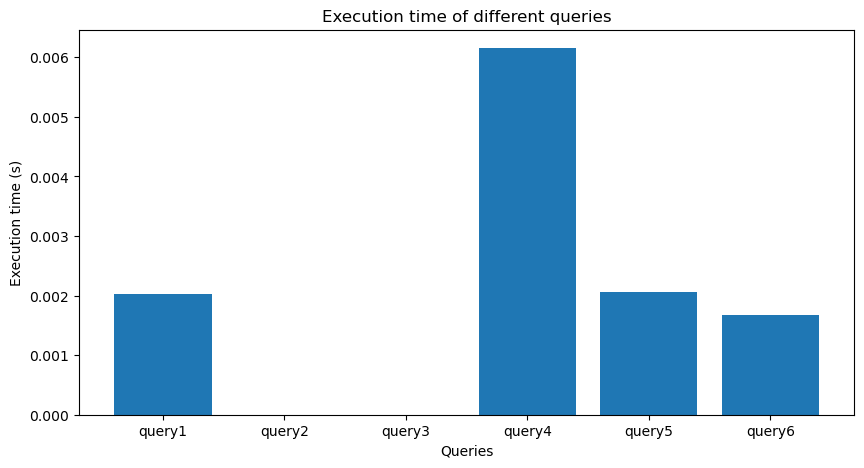

In [23]:
#sample queries
import time
mydb = mysql.connector.connect(
    host="localhost",
    user= "root",
    passwd="free_palestine",
    database="mamluk_jerusalem"
)

mycursor = mydb.cursor()
queries = []
name = building_df["name"].sample().values[0]
query1 = "SELECT * FROM building WHERE name = '{}'".format(name)
queries.append(query1)
query2 = "SELECT * FROM building"
queries.append(query2)
query3 = "SELECT name, modern_name FROM building"
queries.append(query3)	
query4 = "SELECT COUNT(*) FROM date"
queries.append(query4)
query5 = "SELECT COUNT(DISTINCT subtitles) FROM architecture"
queries.append(query5)
query6 = "SELECT * FROM building JOIN date ON building.date_id = date.id"
queries.append(query6)

execution_times = []
for query in queries:
    start = time.time()
    mycursor.execute(query)
    mycursor.fetchall()
    end = time.time()
    execution_times.append(end - start)

#plot execution times
plt.figure(figsize=(10, 5))
plt.bar(range(len(queries)), execution_times)
plt.xticks(range(len(queries)), ["query1", "query2", "query3", "query4", "query5", "query6"])
plt.xlabel("Queries")
plt.ylabel("Execution time (s)")
plt.title("Execution time of different queries")
plt.show()

True

Map(center=[31.778537270506632, 35.23373808554565], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Map(center=[31.778537270506632, 35.23373808554565], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
#date and inscriptions theme